In [15]:
import sys, os

# Point to project root (one level above /notebooks)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)

print("Project root added to PYTHONPATH:", project_root)


Project root added to PYTHONPATH: /home/jasnoorpannu/CSE/Projects/dropout-predictor


In [16]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_curve,
    precision_recall_curve
)

from src.config import RAW_DATA, MODEL_PATH
from src.preprocessing import prepare_features


In [17]:
df_raw = pd.read_csv(RAW_DATA)
df = prepare_features(df_raw)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (26074, 10)


,id_student,total_clicks,avg_clicks,max_daily_clicks,min_daily_clicks,std_clicks,active_days,engagement_trend,days_since_last_active,dropout
0,6516,2791.0,17.553459,142.0,1.0,20.385105,159,-0.055514,0.0,0
1,8462,656.0,11.714286,136.0,1.0,20.290360,56,-0.347163,151.0,1
2,11391,934.0,23.350000,127.0,1.0,27.820441,40,-0.663790,16.0,0
3,23629,161.0,10.062500,26.0,1.0,6.607761,16,0.192647,182.0,0
4,23698,910.0,13.000000,128.0,1.0,23.474933,70,0.026489,38.0,0


In [18]:
from sklearn.model_selection import train_test_split

X = df.drop(["id_student", "dropout"], axis=1)
y = df["dropout"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(X_train.shape, X_val.shape)

(20859, 8) (5215, 8)


In [19]:
model = joblib.load(MODEL_PATH)
model

In [ ]:
# Predictions + sample preview
preds = model.predict(X_val)
pred_labels = (preds > 0.5).astype(int)

print("Sample predicted probabilities:", preds[:5])


ValueError: train and valid dataset categorical_feature do not match.

In [ ]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_fscore_support
)

auc = roc_auc_score(y_val, preds)
ap = average_precision_score(y_val, preds)

precision, recall, f1, _ = precision_recall_fscore_support(
    y_val, pred_labels, average='binary'
)

print(f"AUC: {auc:.4f}")
print(f"Average Precision: {ap:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


AUC: 0.8505
Average Precision: 0.6892
Precision: 0.6653
Recall:    0.6049
F1 Score:  0.6337


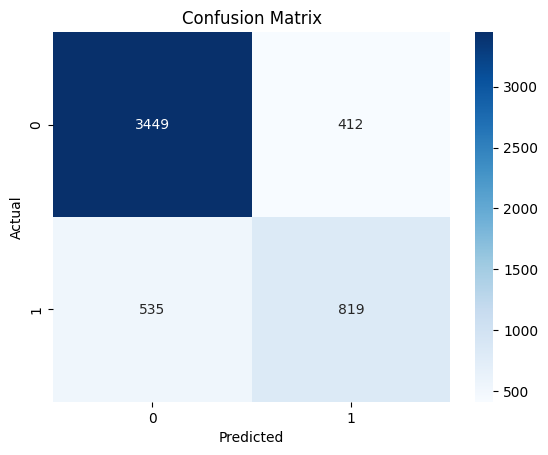

In [ ]:
cm = confusion_matrix(y_val, pred_labels)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

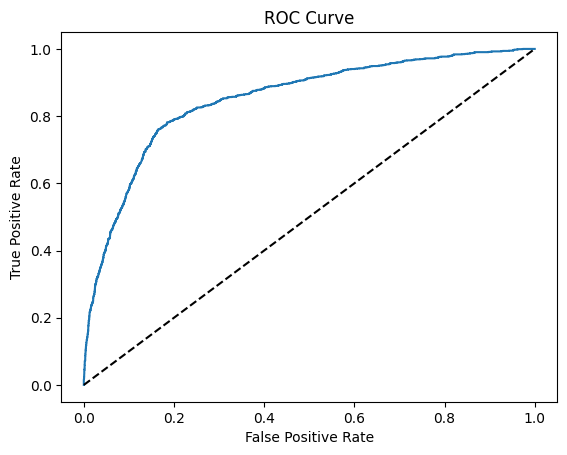

In [ ]:
fpr, tpr, _ = roc_curve(y_val, preds)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

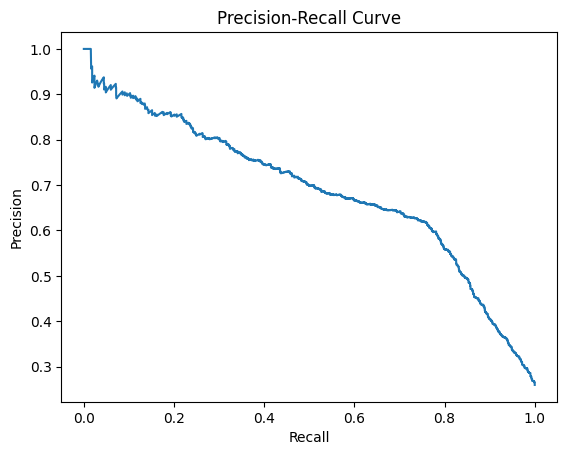

In [ ]:
prec, rec, _ = precision_recall_curve(y_val, preds)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [ ]:
importances = model.feature_importance()
names = model.feature_name()

fi = pd.DataFrame({"feature": names, "importance": importances})
fi = fi.sort_values("importance", ascending=False)
fi

,feature,importance
7,days_since_last_active,930
5,active_days,582
6,engagement_trend,502
2,max_daily_clicks,428
0,total_clicks,382
1,avg_clicks,374
4,std_clicks,331
3,min_daily_clicks,71


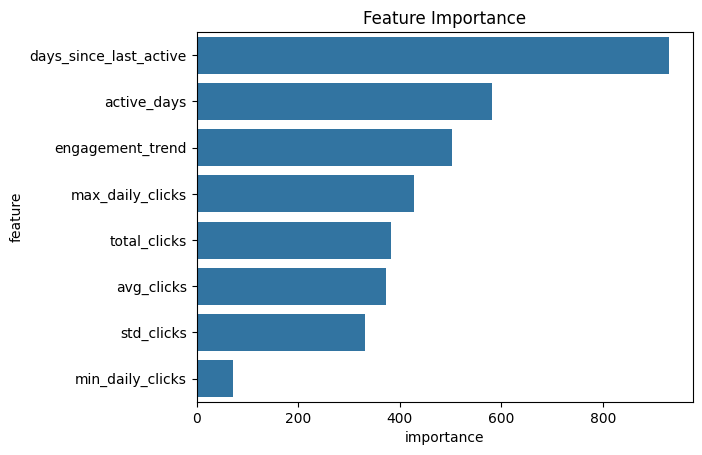

In [ ]:
sns.barplot(data=fi, x="importance", y="feature")
plt.title("Feature Importance")
plt.show()

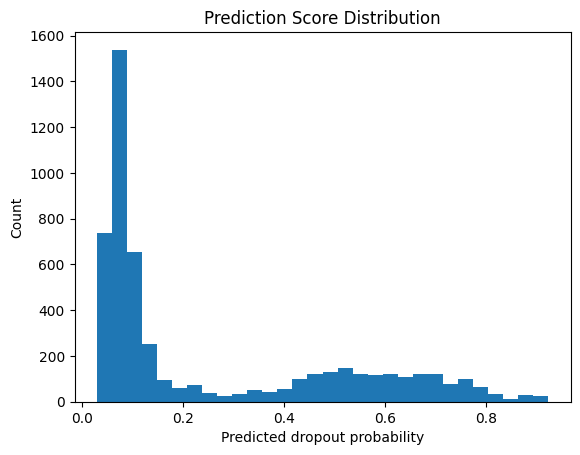

In [ ]:
plt.hist(preds, bins=30)
plt.title("Prediction Score Distribution")
plt.xlabel("Predicted dropout probability")
plt.ylabel("Count")
plt.show()

In [ ]:
scores = []

for seed in [1, 7, 21, 42, 133]:
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=seed
    )

    # retrain simple LGBM just for stability check
    import lightgbm as lgb
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1
    }

    model_temp = lgb.train(params, train_data, valid_sets=[val_data],
                           callbacks=[lgb.early_stopping(50)],
                           num_boost_round=500)

    preds_temp = model_temp.predict(X_val)
    auc_temp = roc_auc_score(y_val, preds_temp)
    scores.append(auc_temp)

scores

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's auc: 0.852239
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's auc: 0.858945
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.863286
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.849455
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	valid_0's auc: 0.851515


[0.8522390132434445,
 0.8589453792555712,
 0.8632864072302772,
 0.8494549517444643,
 0.8515153810574785]